# Train a convolutional neural network to predict MHC ligands
The notebook consists of the following sections:

0. Module imports, define functions, set constants
1. Load Data
2. Build Model
3. Select Hyper-paramerters
4. Instantiate
5. Train Model
6. Evaluation

## Exercise
This exercise will be following the FFNN exercise closely. We will write a function that performs convolutions on a 1D input (i.e. a sequence) across the temporal dimension (i.e. the positions in the sequence). The outputs of the convolution will then be passed to an FFNN that will output a predicted binding affinity value as in the previous exercise. As we have already implemented the FFNN we only need to write the convolution function and then connect it with the FFNN code, using a global max pooling operation.

The CNN architecture is more complex than the FFNN and consequently requires a more efficient implementation in order for it to not be slow to train. Particularly, here we will make use of NumPy's broadcasting functionalities, in order to reduce the number of slow for-loops and multiplication operations we have to make during the forward and backwards passes. You can read more about broadcasting here: https://numpy.org/doc/stable/user/basics.broadcasting.html. 

You should first implement the intuitive version of the CNN using for loops, ensure that your model trains and subsequently use the vectorized version for evaluation. You are of course also welcome to use your own implementation if you have time to wait for it to train.


In [11]:
import numpy as np
import pandas as pd
import math
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, matthews_corrcoef

# Utility functions

In [12]:
# Utility functions you will re-use
# Data-related utility functions
def load_blosum(filename):
    """
    Read in BLOSUM values into matrix.
    """
    aa = ['A', 'R', 'N' ,'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'X']
    df = pd.read_csv(filename, sep='\s+', comment='#', index_col=0)
    return df.loc[aa, aa]

def load_peptide_target(filename):
    """
    Read amino acid sequence of peptides and
    corresponding log transformed IC50 binding values from text file.
    """
    df = pd.read_csv(filename, sep='\s+', usecols=[0,1], names=['peptide','target'])
    return df.sort_values(by='target', ascending=False).reset_index(drop=True)

def encode_peptides(X_in, blosum_file, max_pep_len=9):
    """
    Encode AA seq of peptides using BLOSUM50.
    Returns a tensor of encoded peptides of shape (1, max_pep_len, n_features) for a single batch
    """
    blosum = load_blosum(blosum_file)
    
    batch_size = len(X_in)
    n_features = len(blosum)
    
    X_out = np.zeros((batch_size, max_pep_len, n_features), dtype=np.int8)
    
    for peptide_index, row in X_in.iterrows():
        for aa_index in range(len(row.peptide)):
            X_out[peptide_index, aa_index] = blosum[ row.peptide[aa_index] ].values
            
    return X_out, np.expand_dims(X_in.target.values,1)


In [13]:
# Misc. functions
def invoke(early_stopping, loss, model, implement=False):
    if implement == False:
        return False
    else:
        early_stopping(loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            return True
        
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_losses(train_losses, valid_losses, n_epochs):
    # Plotting the losses 
    fig,ax = plt.subplots(1,1, figsize=(9,5))
    ax.plot(range(n_epochs), train_losses, label='Train loss', c='b')
    ax.plot(range(n_epochs), valid_losses, label='Valid loss', c='m')
    ax.legend()
    fig.show()

In [14]:
# Model saving and loading functions

def save_cnn_model(filepath, model):
    if not filepath.endswith('.pkl'):
        filepath = filepath+'.pkl'
    with open(filepath, 'wb') as f:
        dict_to_save = {'filter_size': model.filter.shape[0], 'input_size': model.filter.shape[1], 'n_filters': model.filter.shape[2], 'ffnn_hidden_size':model.ffnn.W1.shape[1], 'output_size':model.ffnn.W2.shape[1],
                        'W1': model.ffnn.W1, 'b1':model.ffnn.b1, 'W2':model.ffnn.W2, 'b2':model.ffnn.b2, "filter": model.filter,}
        pickle.dump(dict_to_save, f)
        print(f'Saved CNN model at {filepath}')


def load_cnn_model(filepath, model=None):

    with open(filepath, 'rb') as f:
        loaded_dict = pickle.load(f)
    if model is None:
            model = SimpleCNN_vectorized(loaded_dict['filter_size'], loaded_dict['input_size'], loaded_dict['n_filters'], loaded_dict['ffnn_hidden_size'], loaded_dict['output_size'])
    assert (model.filter.shape[0]==loaded_dict['filter_size'] and model.filter.shape[1]==loaded_dict['input_size'] and model.filter.shape[2]==loaded_dict['n_filters'] and model.ffnn.W1.shape[1]==loaded_dict['ffnn_hidden_size'] and model.ffnn.W2.shape[1]==loaded_dict['output_size']), \
        f"Model and loaded weights size mismatch!. Provided model has weight of dimensions {model.ffnn.W1.shape, model.ffnn.W2.shape, model.filter.shape} ; Loaded weights have shape {loaded_dict['W1'].shape, loaded_dict['W2'].shape, loaded_dict['filter'].shape}"

    model.ffnn.W1 = loaded_dict['W1']
    model.ffnn.b1 = loaded_dict['b1']
    model.ffnn.W2 = loaded_dict['W2']
    model.ffnn.b2 = loaded_dict['b2']
    model.filter = loaded_dict['filter']
    print(f"Model loaded successfully from {filepath}\nwith weights [ W1, W2, filter] dimensions : {model.ffnn.W1.shape, model.ffnn.W2.shape, model.filter.shape}")
    return model

# Data loading and encoding

In [15]:
# Replace your data paths with the actual paths and desired alleles
ALLELE =  'A0301' #'A0201'
DATAPATH = '../../data/NNDeep/'
savepath = DATAPATH + "prefix" # NOTE: Change this to your desired save path when converting to scripts
blosum_file = f'{DATAPATH}/BLOSUM50'
train_data = f'{DATAPATH}/{ALLELE}/train_BA'
valid_data = f'{DATAPATH}/{ALLELE}/valid_BA'
test_data = f'{DATAPATH}/{ALLELE}/test_BA'

# Loading the peptides.
train_raw = load_peptide_target(train_data)
valid_raw = load_peptide_target(valid_data)
test_raw = load_peptide_target(test_data)
# 
print('Preview of the dataframe ; Peptides have to be *encoded* to BLOSUM matrices')
display(train_raw.head())

print('N_datapoints:')
print('Train data:\t', train_raw.shape[0])
print('Valid data:\t', valid_raw.shape[0])
print('Test data:\t', test_raw.shape[0])

print('Maximum peptide length of each data set:')
print('Train:\t',  train_raw['peptide'].apply(len).max())
print('Valid:\t', valid_raw['peptide'].apply(len).max())
print('Test:\t', test_raw['peptide'].apply(len).max())


Preview of the dataframe ; Peptides have to be *encoded* to BLOSUM matrices


,peptide,target
0,ATSTRHPSK,1.0
1,RSYSPRNSR,1.0
2,ALYYVHSLLY,1.0
3,LVKSSFVKK,1.0
4,VTFRERYSYK,1.0


N_datapoints:
Train data:	 3951
Valid data:	 1329
Test data:	 1321
Maximum peptide length of each data set:
Train:	 11
Valid:	 11
Test:	 11


Peptide encoding : 

We need to ensure that every peptide shorter than the maximum length `max_len_pep` are *padded* to that length when building the matrices, in order for the dimensions to fit. For example, if our `max_pep_len` is 11, then every peptide of length shorter than 11 must be padded to 11. 

For example, for a peptide "GILGFVFTL", of size 9, and a `max_pep_len` of 11, this effectively means that the peptide is first padded to 11 : "GILGFVFTLXX", where "x" means a pad, and then converted to a matrix. Note here, that the CNN can take a sequence of arrays as input and we no longer need to flatten the input array along the encoding dimension. Thus the X array will be 3-dimensional with dimensions (data_length, peptide_length, encoding_length).



In [16]:
max_pep_len = train_raw.peptide.apply(len).max()
x_train_, y_train_ = encode_peptides(train_raw, blosum_file, max_pep_len)
x_valid_, y_valid_ = encode_peptides(valid_raw, blosum_file, max_pep_len)
x_test_, y_test_ = encode_peptides(test_raw, blosum_file, max_pep_len)

# We now have matrices of shape (N_datapoints, max_pep_len, n_features)
print(x_train_.shape)
#Observations, maximum_nr of peptides, nr of features: 20 AA's +1 x = 21

(3951, 11, 21)


# Model definition

Now it's your turn. We are using a class structure, where a class contains `methods` needed for the forward pass (that just means functions that belong to a class) and you will code the derivatives and backpropagation separately.

For the forward pass, you will need to define the shape of your weight and bias matrices, as well as the actual `forward` pass in terms of matrix multiplications. Additionally, as we are using neural networks, you will also need to code the activation functions (ReLU and Sigmoid).

In [17]:
# Weights initialization function.
# xavier initialization is technically more stable and preferred 
# (See slides)
def xavier_initialization_normal(filter_size, input_size, n_filters):
    shape = (filter_size, input_size, n_filters)
    fan_in = filter_size * input_size
    fan_out = filter_size * n_filters
    stddev = np.sqrt(2 / (fan_in + fan_out))
    return np.random.normal(0, stddev, size=shape) * 0.1

def xavier_initialization_normal_ffnn(input_dim, output_dim):
    shape = (input_dim, output_dim)
    stddev = np.sqrt(2 / (input_dim + output_dim))
    return np.random.normal(0, stddev, size=shape) * 0.1

def random_initialization_normal(input_dim, output_dim):
    return np.random.randn(input_dim, output_dim) * 0.1

In [18]:
def train_network(net, x_train, y_train, learning_rate):
    """
    Trains the network for a single epoch, running the forward and backward pass, and compute and return the loss.
    """
    # Forward pass
    conv_output, pooled_output, pool_indices, relu_output, z1, a1, z2, a2,  = net.forward(x_train)
    # backward pass
    backward(net, x_train, y_train, conv_output, pooled_output, pool_indices, relu_output, z1, a1, z2, a2, learning_rate)
    loss = np.mean((a2 - y_train) ** 2)
    return loss
        
def eval_network(net, x_valid, y_valid):
    """
    Evaluates the network ; Note that we do not update weights (no backward pass)
    """
    conv_output, pooled_output, pool_indices, relu_output, z1, a1, z2, a2, = net.forward(x_valid)
    loss = np.mean((a2-y_valid)**2)
    return loss


# Now create a model and run it.

Play around with the hyperparameters (number of epochs, learning rate, hidden size) and see what the changes do!

In [19]:
# FFN part
class SimpleFFNN:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights and biases with small random values
        self.W1 = xavier_initialization_normal_ffnn(input_size, hidden_size)
        self.b1 = np.zeros(hidden_size)
        self.W2 = xavier_initialization_normal_ffnn(hidden_size, output_size)
        self.b2 = np.zeros(output_size)
    
    def relu(self, x):
        return np.maximum(0, x)

    def sigmoid(self, x): 
        # This is equivalent to : 
        # if x>=0, then compute (1/(1+np.exp(-x)))
        # else: compute (np.exp(x)/(1+np.exp(x))))
        return np.where(x >= 0, 1 / (1 + np.exp(-x)), 
                        np.exp(x) / (1 + np.exp(x)))

    def forward(self, x):
        """
        zi denotes the output of a hidden layer i
        ai denotes the output of an activation function at layer i
        (activations are relu, sigmoid, tanh, etc.)
        """

        # First layer
        z1 = np.dot(x, self.W1) + self.b1
        a1 = self.relu(z1)
        
        # Output layer
        z2 = np.dot(a1, self.W2) + self.b2
        a2 = self.sigmoid(z2)
        
        # Return all the intermediate outputs as well because we need them for backpropagation (see slides)
        return z1, a1, z2, a2


class SimpleCNN:
    def __init__(self, filter_size, input_size, n_filters, hidden_size, output_size):
        self.filter = xavier_initialization_normal(filter_size, input_size, n_filters)
        self.bias = np.zeros((1, 1, n_filters))
        self.ffnn = SimpleFFNN(n_filters, hidden_size, output_size)

    def conv1d(self, batch_x):
        batch_size, input_length, input_size = batch_x.shape
        filter_size, _, n_filters = self.filter.shape
        output_length = input_length - filter_size + 1
        batch_output = np.zeros((batch_size, output_length, n_filters))

        # Loop through each sample in the batch
        for b in range(batch_size):
            for i in range(output_length):
                for k in range(n_filters):
                    # Extract the slice of input for the current position. Hint: we need to slice batch_x like [b, XX, :]
                    input_slice = batch_x[b, i:i + filter_size, :] #XX
                    # Do element-wise multiplication of input slice filter k and sum. Hint: we need to slice the filter tensor and bias like this [:, :, k]
                    batch_output[b, i, k] = np.sum(self.filter[:,:,k] * input_slice) + self.bias[:,:,k] #XX

        return batch_output

    def relu(self, x):
        return np.maximum(0, x)

    def global_max_pooling(self, x):
        # Find the maximum value for each feature map and its index. Hint: look at np.max and np.argmax
        pool_indices = np.argmax(x, axis = 1) #XX
        max_pool = np.max(x, axis = 1) #XX
        return max_pool, pool_indices

    def forward(self, x):
        # Pass the input through the convolution layer
        conv_output = self.conv1d(x)
        # Apply global max pooling
        pooled_outout, pool_indices = self.global_max_pooling(conv_output)
        # Apply the ReLU activation function
        relu_output = self.relu(pooled_outout)
        
        # Pass the result through the feedforward neural network. Hint: unroll the output of the forward function like this *XX
        return conv_output, pooled_outout, pool_indices, relu_output, *self.ffnn.forward(relu_output)


def relu_derivative(x):
    return (x > 0).astype(float)

def sigmoid_derivative(x):
    return x * (1 - x)

def backward(net, x, y, conv_output, pooled_output, pool_indices, relu_output, z1, a1, z2, a2, learning_rate=0.01):
    # Backwards pass for the FFNN
    error = a2 - y
    d_output = error * sigmoid_derivative(a2)

    d_W2 = np.dot(a1.T, d_output)
    d_b2 = np.sum(d_output, axis=0, keepdims=True)

    error_hidden_layer = np.dot(d_output, net.ffnn.W2.T)
    d_hidden_layer = error_hidden_layer * relu_derivative(a1)

    d_W1 = np.dot(relu_output.T, d_hidden_layer)
    d_b1 = np.sum(d_hidden_layer, axis=0, keepdims=True)

    # Propagate the error back to the pooled layer. Hint: look at how we calculated the gradients for the previous layers.
    error_pool = np.dot(d_hidden_layer, net.ffnn.W1.T) #XX
    d_pool = error_pool * relu_derivative(relu_output) #XX

    # Propagate the error to the convolution
    batch_size, input_length, input_size = x.shape
    filter_size, input_size, n_filters = net.filter.shape
    d_conv = np.zeros_like(conv_output)
    for b in range(batch_size):
        # Loop through each output channel
        for k in range(n_filters):
            # Get the index of the maximum value in the pooled output for this sample and channel. Hint: we kept track of this with pool_indices.
            max_index = pool_indices[b, k] #XX
            # Fill out the d_conv matrix at the max indices using the d_pool value for input b and filter k
            d_conv[b, max_index, k] = d_pool[b, k] #XX
    d_bias = np.sum(d_conv, axis=(0, 1), keepdims=True)

    # Calculate the gradient for the convolution filter. 
    d_filter = np.zeros_like(net.filter)
    output_length = input_length - filter_size + 1
    for b in range(batch_size):
        # Loop through each position in the convolution output
        for i in range(output_length):
            # Extract the input slice corresponding to the current position. Hint: we need to slice x like [b, XX, :]
            input_slice = x[b, i:i + output_length, :]
            # Loop through each output channel
            for k in range(n_filters):
                # Accumulate the gradient for the filter by multiplying the input slice with the corresponding gradient from d_conv.
                # Hint for slicing d_conv: look at the dimensions of d_conv and which values are used in the loops.
                d_filter[:, :, k] += np.sum(d_conv[b, i, k] * input_slice)

    # Update the filter weights and the weights and biases of the FFNN
    net.filter -= learning_rate * d_filter #XX
    net.bias -= learning_rate * d_bias.squeeze() #XX
    net.ffnn.W1 -= learning_rate * d_W1
    net.ffnn.b1 -= learning_rate * d_b1.squeeze()
    net.ffnn.W2 -= learning_rate * d_W2
    net.ffnn.b2 -= learning_rate * d_b2.squeeze()

In [20]:
import numpy as np

a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Find the index of the maximum value in the entire array
max_index = np.argmax(a)
print("Index of max value:", max_index)  # Output: 8

# Find the indices of the maximum values along axis 0 (column-wise)
max_index_axis0 = np.argmax(a, axis=0)
print("Indices of max values along axis 0:", max_index_axis0)  # Output: [2 2 2]

# Find the indices of the maximum values along axis 1 (row-wise)
max_index_axis1 = np.argmax(a, axis=1)
print("Indices of max values along axis 1:", max_index_axis1)  # Output: [2 2 2]


Index of max value: 8
Indices of max values along axis 0: [2 2 2]
Indices of max values along axis 1: [2 2 2]


In [21]:
class SimpleCNN_vectorized:
    def __init__(self, filter_size, input_size, n_filters, hidden_size, output_size):
        self.filter = xavier_initialization_normal(filter_size, input_size, n_filters)
        self.bias = np.zeros((1, 1, n_filters))
        self.ffnn = SimpleFFNN(n_filters, hidden_size, output_size)

    def conv1d(self, batch_x):
        batch_size, input_length, input_size = batch_x.shape
        filter_size, _, n_filters = self.filter.shape
        output_length = input_length - filter_size + 1
        batch_output = np.zeros((batch_size, output_length, n_filters))

        # Apply filters to each input slice of the input tensor
        for i in range(output_length):
            input_slice = batch_x[:, i:i + filter_size, :, None]  # Shape: (batch_size, filter_size, input_size, 1)
            batch_output[:, i, :] = np.sum(input_slice * self.filter, axis=(1, 2)) + self.bias
    
        return batch_output

    def relu(self, x):
        return np.maximum(0, x)

    def global_max_pooling(self, x):
        # Find the maximum value for each feature map and its index. Hint: look at np.max and np.argmax
        pool_indices = np.argmax(x, axis=1)
        max_pool = np.max(x, axis=1)
        return max_pool, pool_indices

    def forward(self, x):
        # Pass the input through the convolution layer
        conv_output = self.conv1d(x)
        # Apply global max pooling
        pooled_output, pool_indices = self.global_max_pooling(conv_output)
        # Apply the ReLU activation function
        relu_output = self.relu(pooled_output)
        
        # Pass the result through the feedforward neural network. Hint: unroll the output of the forward function like this *XX
        return conv_output, pooled_output, pool_indices, relu_output, *self.ffnn.forward(relu_output)


def backward(net, x, y, conv_output, pooled_output, pool_indices, relu_output, z1, a1, z2, a2, learning_rate=0.01):
    # Backwards pass for the FFNN
    error = a2 - y
    d_output = error * sigmoid_derivative(a2)

    d_W2 = np.dot(a1.T, d_output)
    d_b2 = np.sum(d_output, axis=0, keepdims=True)

    error_hidden_layer = np.dot(d_output, net.ffnn.W2.T)
    d_hidden_layer = error_hidden_layer * relu_derivative(a1)

    d_W1 = np.dot(relu_output.T, d_hidden_layer)
    d_b1 = np.sum(d_hidden_layer, axis=0, keepdims=True)

    # Propagate the error back to the pooled layer
    error_pool = np.dot(d_hidden_layer, net.ffnn.W1.T)
    d_pool = error_pool * relu_derivative(pooled_output)

    # Propagate the error to the convolution
    batch_size, input_length, input_size = x.shape
    filter_size, input_size, n_filters = net.filter.shape
    d_conv = np.zeros_like(conv_output)
    batch_indices = np.arange(len(x))[:, None]
    d_conv[batch_indices, pool_indices, :] = d_pool[:, None, :]
    d_bias = np.sum(d_conv, axis=(0, 1), keepdims=True)

    # Calculate the gradient for the convolution filter.
    d_filter = np.zeros_like(net.filter)
    output_length = input_length - filter_size + 1
    for i in range(output_length):
        # Extract slices for all batches and all positions
        input_slice_batch = x[:, i:i + filter_size, :, None]  # Shape: (batch_size, filter_size, input_size, 1)
        d_conv_slice = d_conv[:, i, None, :]  # Shape: (batch_size, 1, n_filters)

        # Correct the shape for broadcasting
        d_conv_slice = d_conv_slice[:, :, None, :]  # Shape: (batch_size, 1, 1, n_filters)

        # Accumulate gradients
        d_filter += np.sum(input_slice_batch * d_conv_slice, axis=0)  # Sum over batch_size axis

    # Update the filter weights and the weights and biases of the FFNN
    net.filter -= learning_rate * d_filter
    net.bias -= learning_rate * d_bias.squeeze()
    net.ffnn.W1 -= learning_rate * d_W1
    net.ffnn.b1 -= learning_rate * d_b1.squeeze()
    net.ffnn.W2 -= learning_rate * d_W2
    net.ffnn.b2 -= learning_rate * d_b2.squeeze()

In [25]:
# Define sizes
input_size = x_train_.shape[2] # also known as "n_features"

# Model and training hyperparameters
learning_rate = 0.0001
hidden_units = 50
n_filters = 16
filter_size = 5
n_epochs = 50
output_size = 1
# Creating a model instance 

# Neural Network training here
#network = SimpleCNN(filter_size=filter_size, input_size=input_size, n_filters=n_filters, 
#                    hidden_size=hidden_units, output_size=output_size)

# Vectorized version
network = SimpleCNN_vectorized(filter_size=filter_size, input_size=input_size, n_filters=n_filters, 
                     hidden_size=hidden_units, output_size=output_size)

Epoch 0: 
	Train Loss:0.1044	Valid Loss:0.1063
Epoch 1: 
	Train Loss:0.1025	Valid Loss:0.1044
Epoch 2: 
	Train Loss:0.1006	Valid Loss:0.1025
Epoch 3: 
	Train Loss:0.0989	Valid Loss:0.1008
Epoch 4: 
	Train Loss:0.0972	Valid Loss:0.0991
Epoch 5: 
	Train Loss:0.0956	Valid Loss:0.0975
Epoch 6: 
	Train Loss:0.0941	Valid Loss:0.0960
Epoch 7: 
	Train Loss:0.0926	Valid Loss:0.0945
Epoch 8: 
	Train Loss:0.0912	Valid Loss:0.0931
Epoch 9: 
	Train Loss:0.0899	Valid Loss:0.0917
Epoch 10: 
	Train Loss:0.0886	Valid Loss:0.0904
Epoch 11: 
	Train Loss:0.0873	Valid Loss:0.0891
Epoch 12: 
	Train Loss:0.0861	Valid Loss:0.0878
Epoch 13: 
	Train Loss:0.0848	Valid Loss:0.0865
Epoch 14: 
	Train Loss:0.0837	Valid Loss:0.0853
Epoch 15: 
	Train Loss:0.0825	Valid Loss:0.0840
Epoch 16: 
	Train Loss:0.0813	Valid Loss:0.0828
Epoch 17: 
	Train Loss:0.0802	Valid Loss:0.0816
Epoch 18: 
	Train Loss:0.0791	Valid Loss:0.0804
Epoch 19: 
	Train Loss:0.0780	Valid Loss:0.0792
Epoch 20: 
	Train Loss:0.0769	Valid Loss:0.0780
Ep

C:\Users\hostp\AppData\Local\Temp\ipykernel_18240\2461912376.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


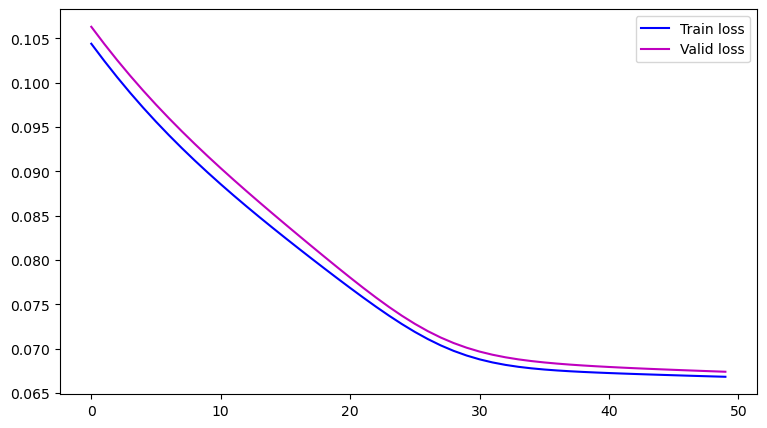

In [26]:
# Training loops
train_losses = []
valid_losses = []

# Run n_epochs of training
for epoch in range(n_epochs):
    train_loss = train_network(network, x_train_, y_train_, learning_rate)
    valid_loss = eval_network(network, x_valid_, y_valid_)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    # For the first, every 1% of the epochs and last epoch, we print the loss 
    # to check that the model is properly training. (loss going down)
    if (n_epochs >= 10 and epoch % math.ceil(0.01 * n_epochs) == 0) or epoch == 0 or epoch == n_epochs:
        print(f"Epoch {epoch}: \n\tTrain Loss:{train_loss:.4f}\tValid Loss:{valid_loss:.4f}")

# saving the model to a file
save_cnn_model(f'{savepath}_saved_cnn.pkl', model=network)

# plotting the losses 
plot_losses(train_losses, valid_losses, n_epochs)

# Evaluation on test data

Model loaded successfully from ../../data/NNDeep/prefix_saved_cnn.pkl
with weights [ W1, W2, filter] dimensions : ((16, 50), (50, 1), (5, 21, 16))


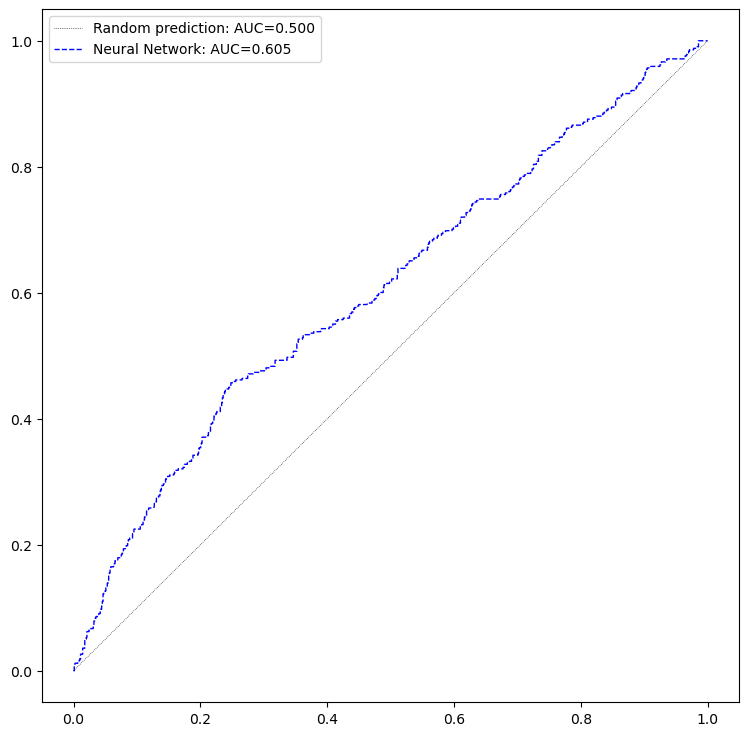

In [27]:
# TODO : Add evaluation / prediction on test data 
#        and get the AUC and other stats plots
from sklearn.metrics import roc_auc_score, roc_curve

# Reload the model and evaluate it
reloaded_network = load_cnn_model(f'{savepath}_saved_cnn.pkl', model=network)

# Thresholding the targets
BINDER_THRESHOLD=0.426
y_test_thresholded = (y_test_>=BINDER_THRESHOLD).astype(int)
_, _, _, _, _, _, _, test_predictions = reloaded_network.forward(x_test_)

# Saving the predictions
test_raw['predictions'] = test_predictions
test_raw[['peptide','predictions','target']].to_csv(f'{savepath}_ffnn_predictions.txt', index=False, header=False)

# Plot ROC curve
test_auc = roc_auc_score(y_test_thresholded.squeeze(), test_predictions.squeeze())
test_fpr, test_tpr, _ = roc_curve(y_test_thresholded.squeeze(), test_predictions.squeeze())

f,a = plt.subplots(1,1 , figsize=(9,9))

a.plot([0,1],[0,1], ls=':', lw=0.5, label='Random prediction: AUC=0.500', c='k')
a.plot(test_fpr, test_tpr, ls='--', lw=1, label=f'Neural Network: AUC={test_auc:.3f}', c='b')
a.legend()

# Argparse part

In [ ]:
# You need to make two scripts train_ffnn.py ; test_ffnn.py: 
#     One for training and saving a model
#     One for loading a saved model and predict

from argparse import ArgumentParser

# Train part
parser = ArgumentParser(description="FFNN train script")
# Data paths
parser.add_argument("-train", action="store", dest="train_data", type=str, help="File with peptides (pep target)")
parser.add_argument("-valid", action="store", dest="valid_data", type=str, help="File with peptides (pep target)")
parser.add_arguemnt("-savepath", action="store", dest="savepath", type=str, default='./CustomName', help='Path to save the result. Used to save the model as {savepath}_ffnn_model.pkl Must not have an extension, ex : ./path/to/my_file')

# Model parameters
parser.add_argument("-nh", action="store", dest="n_hidden", type=int, default=16, help="Number of hidden units")
parser.add_argument("-nf", action="store", dest="n_filters", type=int, default=16, help="Number of CNN filters")
parser.add_argument("-fs", action="store", dest="filter_size", type=int, default=5, help="CNN kernel size")
parser.add_argument("-ne", action="store", dest="n_epochs", type=int, default=500, help="Number of epochs")
parser.add_argument("-lr", action="store", dest="learning_rate", type=float, default=0.0001, help="Learning rate")
args = parser.parse_args()
train_data = parser.train_data
valid_data = parser.valid_data
hidden_size = parser.n_hidden
n_epochs = parser.n_epochs
learning_rate = parser.learning_rate
n_filters = parser.n_filters
filter_size = parser.filter_size
savepath = parser.savepath



In [ ]:

# test part
parser = ArgumentParser(description="FFNN train script")
parser.add_argument("-train", action="store", dest="test_data", type=str, help="File with peptides (pep target)")
parser.add_argument("-nh", action="store", dest="n_hidden", type=int, default=16, help="Number of hidden units")
parser.add_arguemnt("-savepath", action="store", dest="savepath", type=str, default='./CustomName', help='Path to save the result. Used to load the model as {savepath}_ffnn_model.pkl and save the predictions as {savepath}_ffnn_predictions.txt ; Must not have an extension, ex : ./path/to/my_file')
args = parser.parse_args()
test_data = parser.test_data
hidden_size = parser.n_hidden
savepath = parser.savepath